In [1]:
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
from pyimagesearch.SafetyNet import SafetyNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import np_utils, plot_model
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pydot
import pickle
import cv2
import os

args = {
    'dataset' : '/Users/bilal_temp/Downloads/covid_safety_detection/dataset',
    'model' : 'CovidSafety.model',
    'le' : 'le.pickle',
    'plot-model':'SafetyNet.png',
    'plot' : 'results.png'
}

Using TensorFlow backend.
/Users/bilal_temp/Environments/liveness/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/bilal_temp/Environments/liveness/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/bilal_temp/Environments/liveness/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/User

In [17]:
INIT_LR = 1e-4
BS = 32
EPOCHS = 10
IMAGE_SHAPE = (32, 32)

print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))

data = []
labels = []
print('Total images: ', len(imagePaths))

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, IMAGE_SHAPE)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float") / 255.0
print('Total Labels: ',set(labels))

le = LabelEncoder()
labels = le.fit_transform(labels)
labels = np_utils.to_categorical(labels, len(set(labels)))

(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                    test_size=0.30, shuffle=True ,random_state=42)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

[INFO] loading images...
Total images:  690
Total Labels:  {'unsafe', 'safe'}
(483, 32, 32, 3) (483, 2)
(207, 32, 32, 3) (207, 2)


In [12]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=10, width_shift_range=0.2, 
                    height_shift_range=0.2, horizontal_flip=True, fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = SafetyNet.build(width=IMAGE_SHAPE[0], height=IMAGE_SHAPE[1], depth=3, classes=len(le.classes_))
# model.summary()
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] training network for {} epochs...".format(EPOCHS))
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
            validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
            epochs=EPOCHS)

[INFO] training network for 10 epochs...
Epoch 1/10
15/15 [==============================] - 7s 474ms/step - loss: 0.5014 - accuracy: 0.8115 - val_loss: 0.6915 - val_accuracy: 0.4831
Epoch 2/10
15/15 [==============================] - 6s 406ms/step - loss: 0.1480 - accuracy: 0.9579 - val_loss: 0.6764 - val_accuracy: 0.8937
Epoch 3/10
15/15 [==============================] - 6s 421ms/step - loss: 0.0414 - accuracy: 0.9911 - val_loss: 0.6404 - val_accuracy: 0.8502
Epoch 4/10
15/15 [==============================] - 6s 429ms/step - loss: 0.0365 - accuracy: 0.9937 - val_loss: 0.5948 - val_accuracy: 0.7729
Epoch 5/10
15/15 [==============================] - 6s 420ms/step - loss: 0.0612 - accuracy: 0.9867 - val_loss: 0.5530 - val_accuracy: 0.7101
Epoch 6/10
15/15 [==============================] - 6s 387ms/step - loss: 0.1529 - accuracy: 0.9953 - val_loss: 0.5007 - val_accuracy: 0.9952
Epoch 7/10
15/15 [==============================] - 7s 490ms/step - loss: 0.1007 - accuracy: 0.9845 - val_l

In [18]:
try:
    # save model architecture
    plot_model(model, to_file=args['plot-model'])
except Exception as e:
    print(e)
    
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=le.classes_))

# save the network to disk
print("[INFO] serializing network to '{}'...".format(args["model"]))
model.save(args["model"])

# save the label encoder to disk
f = open(args["le"], "wb")
f.write(pickle.dumps(le))
f.close()

`pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.
[INFO] evaluating network...


ValueError: Error when checking input: expected conv2d_21_input to have shape (64, 64, 3) but got array with shape (32, 32, 3)

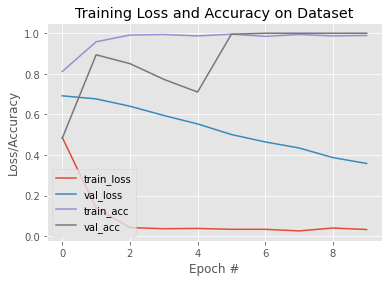

In [14]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])